# Food Recognition

## Imports

In [112]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from itertools import cycle
from sklearn.metrics import (
    roc_curve,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    auc,
    precision_recall_fscore_support
)
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [78]:
def load_images(data_dir, image_size = (240, 240)):
    data = []
    labels = []
    classes = os.listdir(data_dir)[:3]  # Use 3 classes
    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = Image.open(image_path).resize(image_size).convert('RGB')
                image_array = np.array(image)
                data.append(image_array)
                labels.append(class_index)
            except Exception as e:
                print(f"error in loading image {image_path}: {e}")
    return data, labels, classes

data, labels, classes = load_images('images')
data = np.array(data) 
labels = np.array(labels)

## Split dataset into train and test sets

In [79]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

## Print image array and info about arrays

In [80]:
print(f"the number of testing images = {x_test.shape[0]}")  # the number of testing images (first dimensional of x_test)
print(f"the number of training images = {x_train.shape[0]}")  # the number of training images (first dimensional of x_train)
print(x_train.shape[1])  # height of each image (pixels)
print(x_train.shape[2])  # width of each image (pixels) means the image size is (120*120)
print(x_train.shape[3])  # number of color per image => 3 for RGB
print(x_train.shape) # 4D

the number of testing images = 750
the number of training images = 2250
240
240
3
(2250, 240, 240, 3)


## Flatten images

In [81]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print(x_train_flat.shape)

(2250, 172800)


## Build the logistic regression model

In [82]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='ovr')
model.fit(x_train_flat, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr')

## Test cases

In [83]:
y_pred = model.predict(x_test_flat)
y_proba = model.predict_proba(x_test_flat)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:{accuracy:.3f}")

image_path = Image.open('hotdog.jpg').resize((240, 240))
img_ar = np.array(image_path).reshape(1, -1)

predicted_class = model.predict(img_ar)
print(f"Predicted Class: {classes[predicted_class[0]]}")

Accuracy:0.415
Predicted Class: hot_dog


In [84]:
y_pred = model.predict(x_test_flat)
y_proba = model.predict_proba(x_test_flat)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:{accuracy:.3f}")

image_path = Image.open('donuts.jpg').resize((240, 240))
img_ar = np.array(image_path).reshape(1, -1)

predicted_class = model.predict(img_ar)
print(f"Predicted Class: {classes[predicted_class[0]]}")

Accuracy:0.415
Predicted Class: donuts


## KNN Classifier

### Normalize

In [91]:
scaler = MinMaxScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

### Training

In [109]:
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')

knn.fit(x_train_flat, y_train)
y_pred_knn = knn.predict(x_test_flat)
knn_probs = knn.predict_proba(x_test_flat)

accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.421


### Test

In [96]:
image_path = Image.open('hotdog.jpg').resize((240, 240))
img_ar = np.array(image_path).reshape(1, -1)

predicted_class = model.predict(img_ar)
print(f"Predicted Class: {classes[predicted_class[0]]}")

Predicted Class: hot_dog


## Evaluation 

## Confusion Matrix

In [101]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

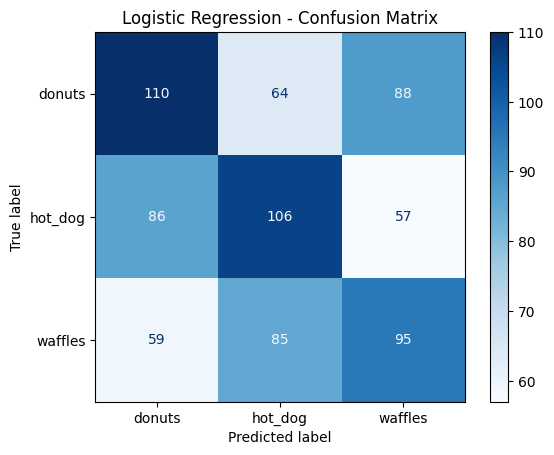

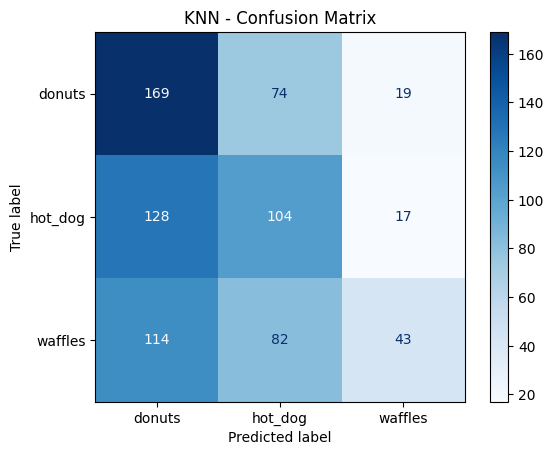

In [102]:
plot_confusion_matrix(y_test, y_pred, "Logistic Regression - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_knn, "KNN - Confusion Matrix")

### Precision, Recall

In [107]:
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"Precision : {precision:.3f}, Recall : {recall:.3f}")

Precision : 0.415, Recall : 0.415


### AUC Scores

In [110]:
log_reg_auc = roc_auc_score(pd.get_dummies(y_test), y_proba, multi_class="ovr")
knn_auc = roc_auc_score(pd.get_dummies(y_test), knn_probs, multi_class="ovr")

print(f"Logistic Regression AUC: {log_reg_auc:.4f}")
print(f"KNN AUC: {knn_auc:.4f}")

Logistic Regression AUC: 0.5971
KNN AUC: 0.5784


In [114]:
def plot_auc_roc_curve(y_true, y_probs, title, num_classes):
    """
    Plot ROC curves for a multi-class classification problem.
    """
    # Convert true labels to one-hot encoding
    y_true_one_hot = pd.get_dummies(y_true).values

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(["blue", "red", "green", "orange", "purple"])
    for i, color in zip(range(num_classes), colors):
        plt.plot(
            fpr[i], tpr[i], color=color,
            lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})"
        )

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], "k--", lw=2, label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

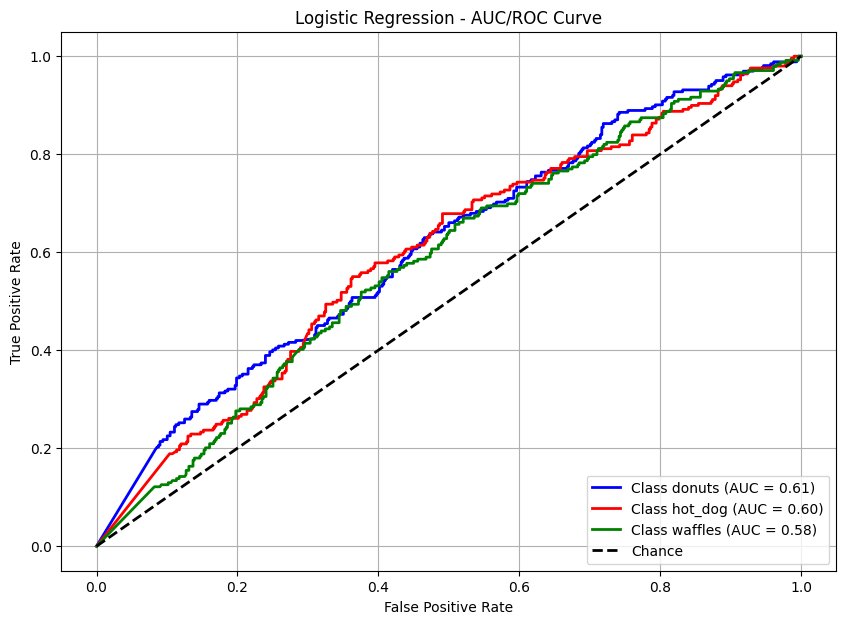

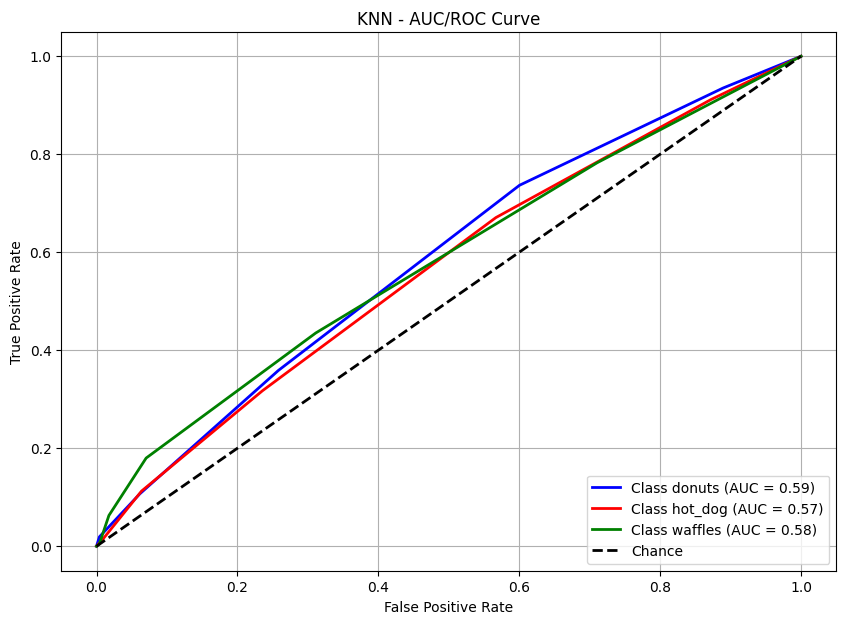

In [116]:
# Plot AUC for Logistic Regression
plot_auc_roc_curve(y_test, y_proba, "Logistic Regression - AUC/ROC Curve", num_classes=len(classes))

# Plot AUC for KNN
plot_auc_roc_curve(y_test, knn_probs, "KNN - AUC/ROC Curve", num_classes=len(classes))


### Accuracy

In [117]:
log_reg_acc = accuracy_score(y_test, y_pred)
knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"Logistic Regression Accuracy: {log_reg_acc:.4f}")
print(f"KNN Accuracy: {knn_acc:.4f}")

Logistic Regression Accuracy: 0.4147
KNN Accuracy: 0.4213


### Loss (Misclassification Rate)

In [118]:
log_reg_loss = 1 - log_reg_acc
knn_loss = 1 - knn_acc
print(f"Logistic Regression Loss (Misclassification Rate): {log_reg_loss:.4f}")
print(f"KNN Loss (Misclassification Rate): {knn_loss:.4f}")

# Classification Reports
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=classes))

Logistic Regression Loss (Misclassification Rate): 0.5853
KNN Loss (Misclassification Rate): 0.5787

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      donuts       0.43      0.42      0.43       262
     hot_dog       0.42      0.43      0.42       249
     waffles       0.40      0.40      0.40       239

    accuracy                           0.41       750
   macro avg       0.41      0.41      0.41       750
weighted avg       0.41      0.41      0.41       750


KNN Classification Report:
              precision    recall  f1-score   support

      donuts       0.41      0.65      0.50       262
     hot_dog       0.40      0.42      0.41       249
     waffles       0.54      0.18      0.27       239

    accuracy                           0.42       750
   macro avg       0.45      0.41      0.39       750
weighted avg       0.45      0.42      0.40       750

